## SGDでのパラメタの更新

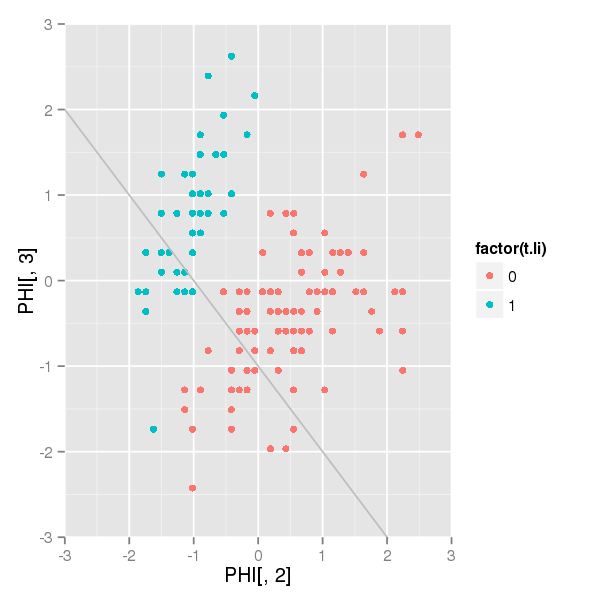

In [14]:
library("dplyr")
library("ggplot2")

x.df <- iris[,1:4] %>% scale
t.li <- iris$Species %>% as.integer %>% ifelse(.>=2,0,.) %>% as.matrix # 2値にしておく

phi <- function(x) c(1, x[1], x[2])
PHI <- t(apply(x.df, 1, phi))  # NxM
M   <- ncol(PHI)  # 特徴数(特徴空間の次元)
K   <- 1 # クラス数
# w   <- matrix(rnorm(M * K), M) # 初期化
w   <- matrix(c(1, 1, 1), M) # 初期化
y <- function(phi, w) {
  ## ロジスティック関数
    a <- phi %*% w
    1 /(1+exp(-a))
}
# y(PHI[c(1,2),],w)

dEw <- function(phi, t.li, w){
  # 誤算関数の勾配
  (y(phi,w)-t.li) * phi
}

a<- -(w[1,]/w[3,])
b<- -(w[2,]/w[3,])
qplot(x=PHI[,2],y=PHI[,3],geom="point",col=factor(t.li))+
  geom_abline(slope=a,intercept=b,col="gray")+
  coord_cartesian(xlim=c(-3,3),y=c(-3,3))

In [15]:
w   <- matrix(c(1, 1, 1), M) # 初期化

mydraw<-function(n,w){
  b<- -(w[1,]/w[3,])
  a<- -(w[2,]/w[3,])
  p<- qplot(x=PHI[,2],y=PHI[,3],geom="point",col=factor(t.li))+
    geom_abline(slope=a,intercept=b,col="gray")+
    coord_cartesian(xlim=c(-3,3),ylim=c(-3,3))+
    ggtitle(paste("n:",n))
  print(p)
}
update_w<-function(loop_cnt=200){
  eta <- 0.1  # 学習率
  i<-1
  for(n in sample(x=1:nrow(PHI),size = loop_cnt,replace = T)) {
    w <<- w -eta * dEw(PHI[n,], t.li[n], w)  # SGD
    mydraw(i,w)
    i<-i+1
  }
}
library("animation")
w   <- matrix(c(1, 1, 1), M) # 初期化
saveGIF(update_w(600),interval = .01,img.name="s",movie.name = "logistic_sgd.gif")
w

Executing: 
'convert' -loop 0 -delay 1 s1.png s2.png s3.png s4.png s5.png s6.png
    s7.png s8.png s9.png s10.png s11.png s12.png s13.png s14.png
    s15.png s16.png s17.png s18.png s19.png s20.png s21.png s22.png
    s23.png s24.png s25.png s26.png s27.png s28.png s29.png s30.png
    s31.png s32.png s33.png s34.png s35.png s36.png s37.png s38.png
    s39.png s40.png s41.png s42.png s43.png s44.png s45.png s46.png
    s47.png s48.png s49.png s50.png s51.png s52.png s53.png s54.png
    s55.png s56.png s57.png s58.png s59.png s60.png s61.png s62.png
    s63.png s64.png s65.png s66.png s67.png s68.png s69.png s70.png
    s71.png s72.png s73.png s74.png s75.png s76.png s77.png s78.png
    s79.png s80.png s81.png s82.png s83.png s84.png s85.png s86.png
    s87.png s88.png s89.png s90.png s91.png s92.png s93.png s94.png
    s95.png s96.png s97.png s98.png s99.png s100.png s101.png s102.png
    s103.png s104.png s105.png s106.png s107.png s108.png s109.png
    s110.png s111.png s112.png s113.

[1] TRUE

-1.664995
-3.233223
2.127222


* wの更新イメージ。本当は境界面も動いて欲しいのだが動かない。
![](logistic_sgd.gif)

あと少しな感じ。

## IRLS

In [16]:
w   <- matrix(c(1, 1, 1), M) # 初期化
update_w_IRLS<-function(){
  N <- dim(y_n)[1]
  error_rate<-function(w_new,w){
    sum((w_new - w)*(w_new - w)) / sum(w*w)
  }
  i<-1
  while(T){
    y_n <- y(PHI,w)
    r_n <- y_n*(1-y_n)
    R_m <- diag(as.numeric(r_n), N, N )
    H <- t(PHI) %*% R_m %*% PHI
    w_new <- w - solve(H) %*% t(PHI) %*% (y_n-t.li)
    if(error_rate(w_new,w) < .00001){
      paste("loop-end:",i) %>% print
      break
    }else{
      w <<- w_new
      i <- i+1
    }
    mydraw(i,w)
  }    
}
# update_w_IRLS()
saveGIF(update_w_IRLS(),interval = .2,img.name="s",movie.name = "logistic_IRLS.gif")
w

ERROR: Error in update_w_IRLS(): object 'y_n' not found


1
1
1


* うまく分離できていない感（汗
![](logistic_IRLS.gif)

もうすこし並行移動してくれたらよさそうなのだけど。。

## （勉強会後）以下、Rの標準関数で試してみる。

(Intercept) Sepal.Length  Sepal.Width 
   -95.94561   -135.31570     60.12127

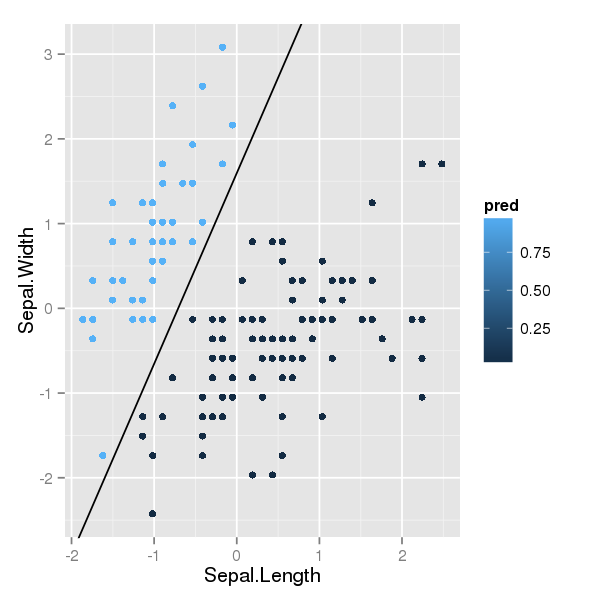

In [12]:
iris.dat <- iris
iris.dat[,1:4] %<>% scale
iris.dat$Species %<>% as.integer %>% ifelse(.>=2,0,.) %>% factor

mod<-glm(data=iris.dat,Species~Sepal.Length+Sepal.Width,family = binomial(link=logit))
# summary(mod)

(w_r <- mod$coefficients)
bb<- -w_r[1]/w_r[3]
aa<- -w_r[2]/w_r[3]
iris.dat$pred <- predict(mod, iris.dat,type = "response")
ggplot(data=iris.dat,aes(x=Sepal.Length,
  y=Sepal.Width,col=pred))+geom_point()+
  geom_abline(slope =aa, intercept =bb)

推定したパラメタの結果が違うので、更新処理で失敗してる模様。